In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

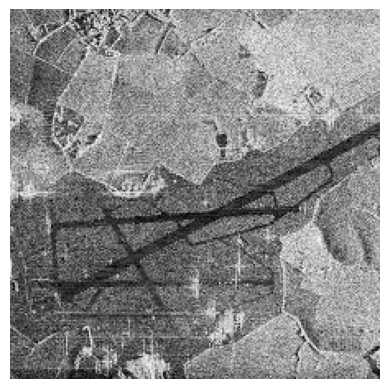

In [39]:
# Загрузка изображения
source_image = cv2.imread('sar_3.jpg')
if source_image is None:
    print("Ошибка: файл не найден")
    exit()

# Преобразование в градации серого
gray_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()


In [40]:
# Детекция границ с помощью Canny
edges = cv2.Canny(gray_image, 100, 150, apertureSize=3)

# Поиск линий с помощью преобразования Хафа
lines = cv2.HoughLines(edges, 1, np.pi / 180, 135)

In [41]:
# Поиск самой длинной линии
max_length = 0
longest_line = None

if lines is not None:
    for line in lines:
        r, t = line[0]
        
        a = np.cos(t)
        b = np.sin(t)
        x0 = a * r
        y0 = b * r
        
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        
        length = np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)
        if length > max_length:
            max_length = length
            longest_line = (pt1, pt2)

if longest_line is not None:
    longest_line_image = source_image.copy()
    cv2.line(longest_line_image, longest_line[0], longest_line[1], (255, 255, 255), 2, cv2.LINE_AA)

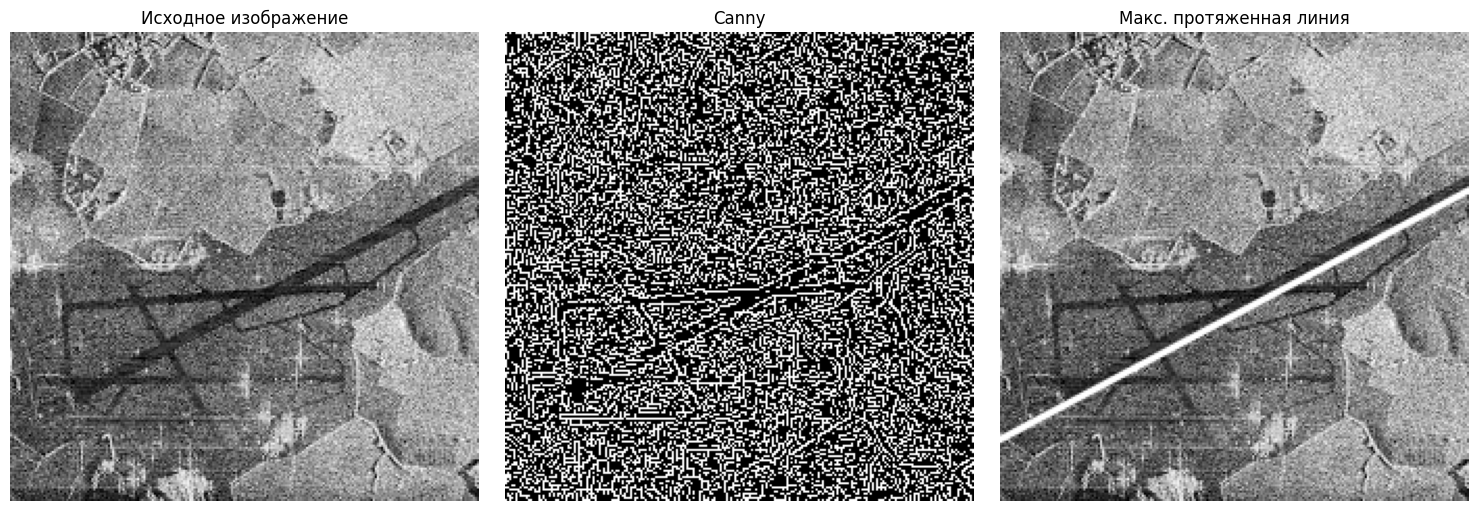

In [42]:
# Отображение результатов
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(longest_line_image, cv2.COLOR_BGR2RGB))
plt.title('Макс. протяженная линия')
plt.axis('off')

plt.tight_layout()
plt.show()

In [63]:
# 1. Простая бинаризация
binary_ret, binary_thresh = cv2.threshold(gray_image, 65, 255, cv2.THRESH_BINARY)

# 2. Бинаризация по методу Отсу
binary_otsu_ret, binary_otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 3. Адаптивная бинаризация (среднее значение)
adaptive_binary_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                cv2.THRESH_BINARY, 101, 45)


blurred = cv2.GaussianBlur(adaptive_binary_thresh, (7, 7), 0)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

road_detected_image = source_image.copy()
if contours:
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:
            cv2.drawContours(road_detected_image, [contour], -1, (0, 255, 0), 1) 


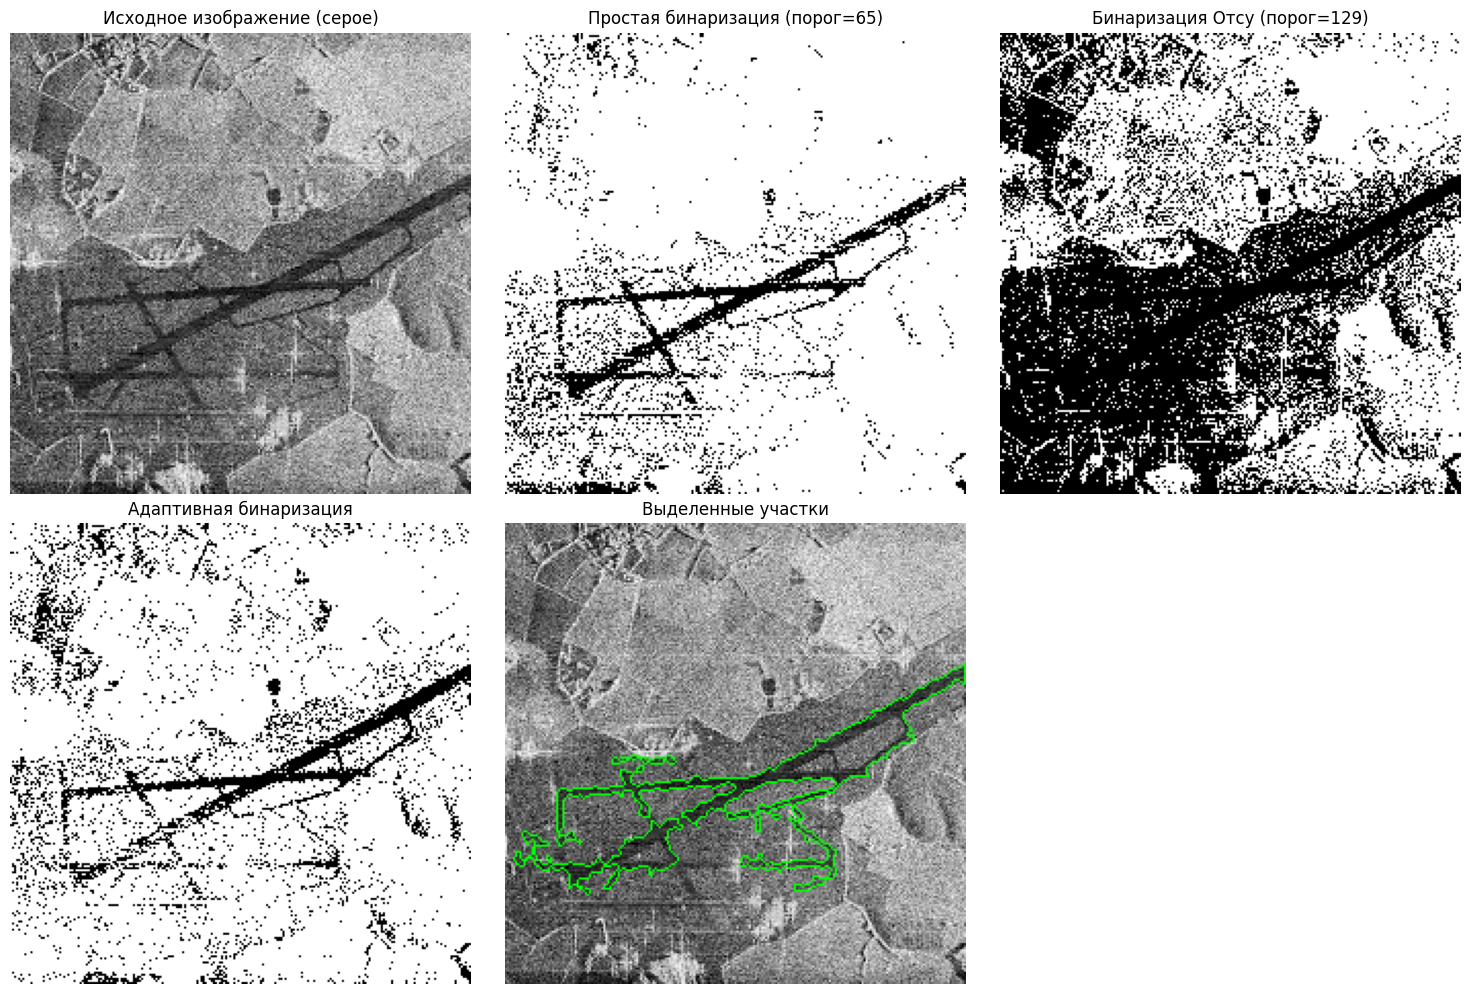

In [64]:
# Отображение результатов
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Исходное изображение (серое)')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(binary_thresh, cmap='gray')
plt.title('Простая бинаризация (порог=65)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(binary_otsu_thresh, cmap='gray')
plt.title(f'Бинаризация Отсу (порог={binary_otsu_ret:.0f})')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(adaptive_binary_thresh, cmap='gray')
plt.title('Адаптивная бинаризация')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(road_detected_image, cv2.COLOR_BGR2RGB))
plt.title('Выделенные участки')
plt.axis('off')

plt.tight_layout()
plt.show()